# Second iteration of model - dynamic network

After some interactions a new link is formed between two random agents 

The first to be defined is a state space, here being set to be discrete values. 
Then the Agent class is defined to set an initial state and a method to "consider" it's state options and possibly changing it's state. 

In [12]:
import numpy as np
from operator import itemgetter
import heapq
import random
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
from copy import deepcopy
import seaborn as sns
#import pygraphviz as pgv
from statistics import stdev, mean
import imageio
import networkx as nx
from scipy.stats import truncnorm
from itertools import repeat
import time
import multiprocessing
import os
from threading import Thread
#from model import Agent

#Constants and Variables

states = [1, -1] #1 being cooperating, -1 being defecting

defectorUtility = -0.20 
 
politicalClimate=0.2 

selfWeight = 0.8

neighboursWeight = 0.5

#Helper
def decision(probability):
    return random.random() < probability

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [13]:

class Agent:
    def __init__(self, state):
        self.state = state
        self.interactionsReceived = 0
        self.interactionsGiven = 0
    
    def consider(self, neighbour, neighboursWeight):
        self.interactionsReceived +=1
        neighbour.addInteractionGiven()
        weight = self.state*selfWeight + politicalClimate + defectorUtility + neighboursWeight*neighbour.state + random.uniform(-0.25, 0.25)
        
        #self.state = weight
        if(weight > 0):
            self.state = states[0]
        else:
            self.state = states[1]  
    
    def addInteractionGiven(self):
        self.interactionsGiven +=1
        
    def groupConsider(self, neighbourList):
        return
        
        
    def groupConsiderA(self, neighbour, neighboursWeight, neighbourList):
        nbNeighbours = len(neighbourList)
        nbCoop = 0
        for n in  neighbourList:
            if(n['agent'].state > 0): nbCoop += 1
        p = nbCoop/nbNeighbours
        self.interactionsReceived +=1
        neighbour.addInteractionGiven()
        if(neighbour.state <= 0):
            p=1-p
        
        
        weight = self.state*selfWeight + politicalClimate + defectorUtility + p*neighboursWeight*neighbour.state + random.uniform(-0.25, 0.25)
        
        #self.state = weight
        if(weight > 0):
            self.state = states[0]
        else:
            self.state = states[1]  
    
    
    def setState(self, newState):
        if(newState >= states[1] and newState <= states[0]):
            self.state = newState
        else:
            print("Error state outside state range: ", newState)
        

The model class consists of the agents and includes a method to make these interact. 

In [14]:
class Model:
    def __init__(self):
        self.graph = nx.Graph()
        self.ratio = []
        self.defectorDefectingNeighsList = []
        self.cooperatorDefectingNeighsList = []
        self.defectorDefectingNeighsSTDList = []
        self.cooperatorDefectingNeighsSTDList =[]
        self.pos = []
    
    def interact(self):
        nodeIndex = random.randint(0, len(self.graph) - 1)
        node = self.graph.nodes[nodeIndex]['agent']
        
        neighbours =  list(self.graph.adj[nodeIndex].keys())
        if(len(neighbours) == 0):
            return
        
        chosenNeighbourIndex = neighbours[random.randint(0, len(neighbours)-1)]
        chosenNeighbour = self.graph.nodes[chosenNeighbourIndex]['agent']
        
        weight = self.graph[nodeIndex][chosenNeighbourIndex]['weight']
        
        node.consider(chosenNeighbour, weight)
        
    def groupInteract(self):
        nodeIndex = random.randint(0, len(self.graph) - 1)
        node = self.graph.nodes[nodeIndex]['agent']
        
        neighbours =  list(self.graph.adj[nodeIndex].keys())
        if(len(neighbours) == 0):
            return
        
        chosenNeighbourIndex = neighbours[random.randint(0, len(neighbours)-1)]
        chosenNeighbour = self.graph.nodes[chosenNeighbourIndex]['agent']
        
        weight = self.graph[nodeIndex][chosenNeighbourIndex]['weight']
        
        neighbourList = [self.graph.nodes[i] for i in neighbours]
        node.groupConsiderA(chosenNeighbour, weight, neighbourList)
        
    def getAvgNumberOfDefectorNeigh(self):
        defectorFriendsList = []
        defectorNeighboursList = []
        for node in self.graph:
            agreeingNeighbours = 0
            neighbours = list(self.graph.adj[node])
            for neighbourIndex in neighbours:
                if self.graph.nodes[neighbourIndex]['agent'].state == self.graph.nodes[node]['agent'].state:
                    agreeingNeighbours += 1
            if self.graph.nodes[node]['agent'].state== 1:
                defectorNeighboursList.append(agreeingNeighbours) #defectorNeighboursList.append(agreeingNeighbours/len(neighbours))
            else:
                defectorFriendsList.append(agreeingNeighbours)
        
        defectoravg = mean(defectorFriendsList)
        cooperatoravg =mean(defectorNeighboursList)
        defectorSTD = stdev(defectorFriendsList)
        cooperatorSTD =stdev(defectorNeighboursList)
        return(defectoravg, cooperatoravg, defectorSTD, cooperatorSTD)
                
    
    def countCooperatorRatio(self):
        count = 0
        for node in self.graph:
            if self.graph.nodes[node]['agent'].state > 0:
                count+=1
        return count/len(self.graph)
 
    def runSim(self, k, groupInteract=False, drawModel = False, countNeighbours = False, gifname=None):
        
        if(drawModel):
            draw_model(self)
            filenames = []
        
        if(countNeighbours):
            (defectorDefectingNeighs,
             cooperatorDefectingFriends,
             defectorDefectingNeighsSTD,
             cooperatorDefectingFriendsSTD) = self.getAvgNumberOfDefectorNeigh()
            print("Defectors: avg: ", defectorDefectingNeighs, " std: ", defectorDefectingNeighsSTD)
            print("Cooperators: avg: ", cooperatorDefectingFriends, " std: ", cooperatorDefectingFriendsSTD)
    
        for i in range(k):
            if(groupInteract): self.groupInteract()
            else:
                self.interact()
            ratio = self.countCooperatorRatio()
            self.ratio.append(ratio)
            #self.politicalClimate += (ratio-0.5)*0.001 #change the political climate depending on the ratio of cooperators
            
            if(countNeighbours):
                (defectorDefectingNeighs,
                 cooperatorDefectingNeighs,
                 defectorDefectingNeighsSTD,
                 cooperatorDefectingNeighsSTD) = self.getAvgNumberOfDefectorNeigh()
                self.defectorDefectingNeighsList.append(defectorDefectingNeighs)
                self.cooperatorDefectingNeighsList.append(cooperatorDefectingNeighs)
                self.defectorDefectingNeighsSTDList.append(defectorDefectingNeighsSTD)
                self.cooperatorDefectingNeighsSTDList.append(cooperatorDefectingNeighsSTD)
            if(drawModel and (gifname != None) and (i % 10 == 0)):
                draw_model(self, True, i)
                filenames.append("plot" + str(i) +".png")
                
            #if(i % 10 == 0):
                #a = random.randint(0,n)
                #b = random.randint(0,n)
                #while(a==b):
                    #b = random.randint(0,n)
                    #weight = random.uniform(0.1, 0.9)
                    #model.graph.add_edge(a, b, weight = weight)
        if(drawModel and (gifname != None)):
            images = []
            for filename in filenames:
                images.append(imageio.imread(filename))
            imageio.mimsave("network" +gifname+ ".gif", images, duration=0.04167)
       
    
        if(countNeighbours):
            drawDefectingNeighbours(self.defectorDefectingNeighsList,
                                    self.cooperatorDefectingNeighsList,
                                    self.defectorDefectingNeighsSTDList,
                                    self.cooperatorDefectingNeighsSTDList, 
                                    gifname)
        
        return self.ratio

In [20]:
class GridModel(Model):
    def __init__(self, n):
        super().__init__()
        for i in range(n):
            for j in range (n):
                weight=random.uniform(0.1, 0.9)
                agent1 = Agent(states[random.randint(0,1)])
                self.graph.add_node(i*n+j, agent=agent1, pos=(i, j))
                self.pos.append((i, j))
                if(i!=0):
                    model.graph.add_edge(i*n+j, (i-1)*n+j, weight = weight)
                if(j!=0):
                    model.graph.add_edge(i*n+j, i*n+j-1, weight = weight)
    

In [19]:
class RandomModel(Model):
    def __init__(self, n, m):
        super().__init__()
        X = get_truncated_normal(0.5, 0.15, 0, 1)
        self.graph =nx.erdos_renyi_graph(n, 0.027972)
        for n in range (n):
                agent1 = Agent(states[random.randint(0,1)])
                self.graph.nodes[n]['agent'] = agent1
        edges = self.graph.edges() 
        for e in edges: 
            #weight=random.uniform(0.1, 0.9)
            weight=X.rvs(1)
            self.graph[e[0]][e[1]]['weight'] = weight 
        self.pos = nx.kamada_kawai_layout(self.graph)
    # bipartite_layout(G, nodes[, align, scale, …])	Position nodes in two straight lines.
    #circular_layout(G[, scale, center, dim])	Position nodes on a circle.
    #kamada_kawai_layout(G[, dist, pos, weight, …])	Position nodes using Kamada-Kawai path-length cost-function.
    #random_layout(G[, center, dim, seed])	Position nodes uniformly at random in the unit square.
    #rescale_layout(pos[, scale])	Return scaled position array to (-scale, scale) in all axes.
    ##shell_layout(G[, nlist, scale, center, dim])	Position nodes in concentric circles.
    #spring_layout(G[, k, pos, fixed, …])	Position nodes using Fruchterman-Reingold force-directed algorithm.
    #spectral_layout(G[, weight, scale, center, dim])	Position nodes using the eigenvectors of the graph Laplacian. 


In [18]:
class ScaleFreeModel(Model):
    def __init__(self, n, m):
        super().__init__()
        X = get_truncated_normal(0.5, 0.15, 0, 1)
        self.graph = nx.barabasi_albert_graph(n, m)
        for n in range (n):
                agent1 = Agent(states[random.randint(0,1)])
                self.graph.nodes[n]['agent'] = agent1
        edges = self.graph.edges() 
        for e in edges: 
            #weight=random.uniform(0.1, 0.9)
            weight=X.rvs(1)
            self.graph[e[0]][e[1]]['weight'] = weight 
        self.pos = nx.kamada_kawai_layout(self.graph)

In [ ]:
def makeGridModel(n):
    model = Model()
    
    for i in range(n):
        for j in range (n):
            weight=random.uniform(0.1, 0.9)
            agent1 = Agent(states[random.randint(0,1)])
            model.graph.add_node(i*n+j, agent=agent1, pos=(i, j))
            model.pos.append((i, j))
            if(i!=0):
                model.graph.add_edge(i*n+j, (i-1)*n+j, weight = weight)
            if(j!=0):
                model.graph.add_edge(i*n+j, i*n+j-1, weight = weight)
    
    return model

In [ ]:
def makeRandomModel(n, m, algorithm="ba"):
    model = Model()
    X = get_truncated_normal(0.5, 0.15, 0, 1)
    if(algorithm == "er"):
        model.graph =nx.erdos_renyi_graph(n, 0.027972)
    else:
        model.graph = nx.barabasi_albert_graph(n, m)
    for n in range (n):
            agent1 = Agent(states[random.randint(0,1)])
            model.graph.nodes[n]['agent'] = agent1
    edges = model.graph.edges() 
    for e in edges: 
        #weight=random.uniform(0.1, 0.9)
        weight=X.rvs(1)
        model.graph[e[0]][e[1]]['weight'] = weight 
    #pos = nx.nx_agraph.graphviz_layout(model.graph)
    #pos = graphviz_layout(model.graph)
    pos = nx.kamada_kawai_layout(model.graph)
# bipartite_layout(G, nodes[, align, scale, …])	Position nodes in two straight lines.
#circular_layout(G[, scale, center, dim])	Position nodes on a circle.
#kamada_kawai_layout(G[, dist, pos, weight, …])	Position nodes using Kamada-Kawai path-length cost-function.
#random_layout(G[, center, dim, seed])	Position nodes uniformly at random in the unit square.
#rescale_layout(pos[, scale])	Return scaled position array to (-scale, scale) in all axes.
##shell_layout(G[, nlist, scale, center, dim])	Position nodes in concentric circles.
#spring_layout(G[, k, pos, fixed, …])	Position nodes using Fruchterman-Reingold force-directed algorithm.
#spectral_layout(G[, weight, scale, center, dim])	Position nodes using the eigenvectors of the graph Laplacian. 

    model.pos = pos
    
    return model

In [15]:
import matplotlib.pyplot as plt
from IPython.display import Image


def draw_model(model, save=False, filenumber = None):
    
    plt.figure(figsize=(16,16))

    color_map = []
    intensities = []
    #pos = []
    for node in model.graph:
        #pos.append(model.graph.nodes[node]['pos'])
        if model.graph.nodes[node]['agent'].state > 0:
            color_map.append((3/255,164/255,94/255, model.graph.nodes[node]['agent'].state))
            intensities.append(model.graph.nodes[node]['agent'].state)
            #color_map.append('#03a45e')
        #else: color_map.append('#f7796d')
        else: 
            color_map.append((247/255,121/255,109/255, -1*model.graph.nodes[node]['agent'].state ))
            intensities.append(model.graph.nodes[node]['agent'].state)
    degrees = nx.degree(model.graph)
    plt.subplot(121)
    nx.draw(model.graph, model.pos, node_size=[d[1] * 20 for d in degrees], node_color =intensities, cmap = plt.cm.RdYlGn )
    if(save):
        plt.savefig("plot" + str(filenumber) +".png", bbox_inches="tight")
        plt.clf()


In [22]:
def simulate( n, k, **kwargs):
    model = makeScaleFreeModel(n, 2)  
    ratio = model.runSim(k, **kwargs)
    return (model, ratio)

def batch_simulate(n,k,s, **kwargs):
    batch_proportions=[]
    q = multiprocessing.Queue()
    #pool = multiprocessing.Pool(processes=3)
    #res = pool.starmap(simulate, zip(repeat(n, s), repeat(k, s)))#SEPÅPROCESS

    for i in range(s):
        print("loop: ", i)
        t = multiprocessing.Process(target=simulate, args=(q, n, k))
        #t.daemon = True
        t.start()
    #    (model, proportion) = simulate(n, k, **kwargs)
    #    batch_proportions.append(proportion)
    batch_proportions = [q.get() for i in range(s)]
    
    return batch_proportions 

In [ ]:
start = time.time()
(proportions) = batch_simulate(144, 300, 10)
end = time.time()
print(f'Time to complete: {end - start:.2f}s\n')
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))
for i in range(100):
    plt.plot(proportions[i])


In [ ]:
radialDist(model, 4, False)
#plt.plot(model.ratio)

In simulate


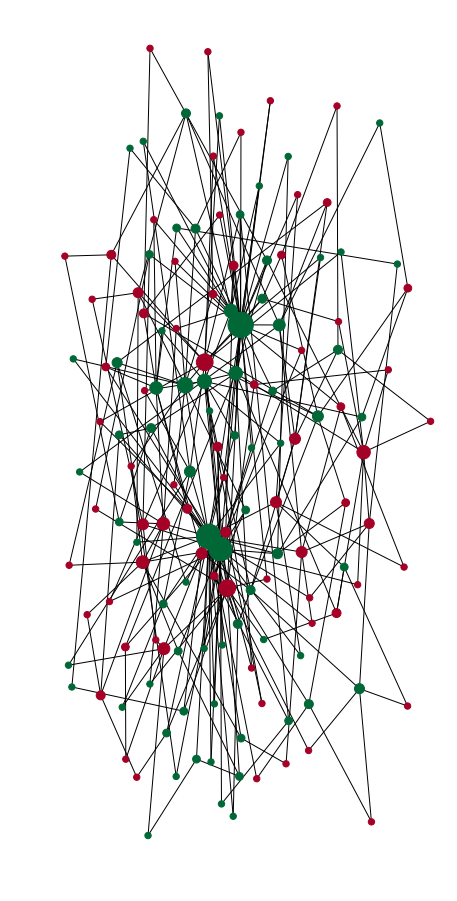

In [23]:
(model, ratio) = simulate(144, 3000, drawModel = True)

In [ ]:
draw_model(model)


## Radial Distribution function
Calculate the number of agreeing nodes per number of jumps out from the node

In [ ]:
def radialDist(model, depth, isBefore):
    DefectorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
    CooperatorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
    
    for nodeIdx in model.graph:
        neighbours = list(model.graph.adj[nodeIdx])
        isCooperator = model.graph.nodes[nodeIdx]['agent'].state > 0
        parent = [nodeIdx]
        for d in range(depth):
            nextLevelNeighs = set([])
            for n in neighbours:
                nextLevelNeighs.update(list(model.graph.adj[n]))
                if(model.graph.nodes[n]['agent'].state > 0 and isCooperator):
                    CooperatorValues[nodeIdx][d] += 1
                elif(model.graph.nodes[n]['agent'].state <= 0 and not isCooperator): 
                    DefectorValues[nodeIdx][d] += 1
            if(len(neighbours) == 0):
                break
            CooperatorValues[nodeIdx][d] = CooperatorValues[nodeIdx][d]/len(neighbours)
            DefectorValues[nodeIdx][d] = DefectorValues[nodeIdx][d]/len(neighbours)
            
            #make sure the parent level isn't checked again
            for n in parent:
                nextLevelNeighs.discard(n) 
            parent = neighbours
            neighbours = nextLevelNeighs
     
    cooperatorRatio = model.countCooperatorRatio()
    
    cooperatorRes = []
    defectorRes = []
    for col in range(depth):
        coopSumRatios = 0
        defectSumRatios = 0
        for row in range(len(CooperatorValues)):
            coopSumRatios += CooperatorValues[row][col]
            defectSumRatios += DefectorValues[row][col]
        cooperatorRes.append(np.array(coopSumRatios)/(len(model.graph)*cooperatorRatio*cooperatorRatio))
        defectorRes.append(np.array(defectSumRatios)/(len(model.graph)*(1-cooperatorRatio)*(1-cooperatorRatio)))

    if isBefore:
        intensity = 0.5
    else:
        intensity = 1
    plt.xlabel("Distance from the nodes")
    plt.ylabel("Normalised ratio of agreein neighbours")
    plt.title("Distance distribution function")
    plt.ylim((0, 2.5))
    plt.plot(range(1, len(cooperatorRes)+1), cooperatorRes, color=((23/255, 104/255, 37/255, intensity)))     
    plt.plot(range(1, len(cooperatorRes)+1), defectorRes, color=((109/255, 10/255, 10/255, intensity))) 

In [ ]:
def avgRadialDist(models, depth, isBefore):
    DefectorList = []
    CooperatorList = []
    
    for model in models :
        DefectorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
        CooperatorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]

        for nodeIdx in model.graph:
            neighbours = list(model.graph.adj[nodeIdx])
            isCooperator = model.graph.nodes[nodeIdx]['agent'].state > 0
            parent = [nodeIdx]
            for d in range(depth):
                nextLevelNeighs = set([])
                for n in neighbours:
                    nextLevelNeighs.update(list(model.graph.adj[n]))
                    if(model.graph.nodes[n]['agent'].state > 0 and isCooperator):
                        CooperatorValues[nodeIdx][d] += 1
                    elif(model.graph.nodes[n]['agent'].state <= 0 and not isCooperator): 
                        DefectorValues[nodeIdx][d] += 1
                if(len(neighbours) == 0):
                    break
                CooperatorValues[nodeIdx][d] = CooperatorValues[nodeIdx][d]/len(neighbours)
                DefectorValues[nodeIdx][d] = DefectorValues[nodeIdx][d]/len(neighbours)

                #make sure the parent level isn't checked again
                for n in parent:
                    nextLevelNeighs.discard(n) 
                parent = neighbours
                neighbours = nextLevelNeighs

        cooperatorRatio = model.countCooperatorRatio()

        cooperatorRes = []
        defectorRes = []
        for col in range(depth):
            coopSumRatios = 0
            defectSumRatios = 0
            for row in range(len(CooperatorValues)):
                coopSumRatios += CooperatorValues[row][col]
                defectSumRatios += DefectorValues[row][col]
            cooperatorRes.append(np.array(coopSumRatios)/(len(model.graph)*cooperatorRatio*cooperatorRatio))
            defectorRes.append(np.array(defectSumRatios)/(len(model.graph)*(1-cooperatorRatio)*(1-cooperatorRatio)))
        DefectorList.append( defectorRes)
        CooperatorList.append( cooperatorRes)
    data = np.array(DefectorList)
    avgDefector = np.average(data, axis=0)
    data = np.array(CooperatorList)
    avgCooperator = np.average(data, axis=0)
            
    if isBefore:
        intensity = 0.5
    else:
        intensity = 1
    plt.xlabel("Distance from the nodes")
    plt.ylabel("Normalised ratio of agreein neighbours")
    plt.title("Distance distribution function")
    plt.ylim((0, 1.8))
    plt.plot(range(1, len(avgDefector)+1), avgCooperator, color=((23/255, 104/255, 37/255, intensity)))     
    plt.plot(range(1, len(avgDefector)+1), avgDefector, color=((109/255, 10/255, 10/255, intensity))) 

In [ ]:
models = []
ratios = []
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))

for i in range(100):
    model=makeRandomModel(160, 2)
    models.append(model)

copyModels = deepcopy(models)
models2 = deepcopy(models)
models3 = deepcopy(models)
models4 = deepcopy(models)
models5 = deepcopy(models)


for i in range(100):
    model = models[i]
    degrees = nx.degree(model.graph)
    #largestHubIdx = max(degrees,key=itemgetter(1))[0]
    largest = heapq.nlargest(2, degrees, key=itemgetter(1))[0]
    for l in range(len(largest)):
        model.graph.nodes[largest[l]]['agent'].setState(1)
    #model.graph.nodes[twolargest[1]]['agent'].setState(1)
    ratio = model.runSim(5000, groupInteract = True)
    ratios.append(ratio)
for i in range(100):
    plt.plot(ratios[i])
endRatioImpacted = [ratios[i][-1] for i in range(len(ratios))]

In [ ]:
models2 = []
ratios2 = []
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))

for i in range(100):
    model=makeRandomModel(160, 2)
    models2.append(model)

copyModels2 = deepcopy(models2)
for i in range(100):
    model = models2[i]
    degrees = nx.degree(model.graph)
    #largestHubIdx = max(degrees,key=itemgetter(1))[0]
    largest = heapq.nlargest(2, degrees, key=itemgetter(1))[0]
    for l in range(len(largest)):
        model.graph.nodes[largest[l]]['agent'].setState(1)
    #model.graph.nodes[twolargest[1]]['agent'].setState(1)
    ratio = model.runSim(5000, groupInteract = True)
    ratios2.append(ratio)
for i in range(100):
    plt.plot(ratios2[i])
endRatioImpacted2 = [ratios2[i][-1] for i in range(len(ratios2))]

In [ ]:
#models3 = deepcopy(models)
ratios3 = []
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))

#for i in range(100):
#    model=makeRandomModel(160, 2)
#    models3.append(model)

#copyModels3 = deepcopy(models3)
for i in range(100):
    model = models3[i]
    degrees = nx.degree(model.graph)
    #largestHubIdx = max(degrees,key=itemgetter(1))[0]
    largest = heapq.nlargest(3, degrees, key=itemgetter(1))[0]
    for l in range(len(largest)):
        model.graph.nodes[largest[l]]['agent'].setState(1)
    #model.graph.nodes[twolargest[1]]['agent'].setState(1)
    ratio = model.runSim(5000, groupInteract = False)
    ratios3.append(ratio)
for i in range(100):
    plt.plot(ratios3[i])
endRatioImpacted3 = [ratios3[i][-1] for i in range(len(ratios3))]

In [ ]:
#models4 = deepcopy(models)
ratios4 = []
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))

#for i in range(100):
#    model=makeRandomModel(160, 2)
#    models4.append(model)

#copyModels4 = deepcopy(models4)
for i in range(100):
    model = models4[i]
    degrees = nx.degree(model.graph)
    #largestHubIdx = max(degrees,key=itemgetter(1))[0]
    largest = heapq.nlargest(4, degrees, key=itemgetter(1))[0]
    for l in range(len(largest)):
        model.graph.nodes[largest[l]]['agent'].setState(1)
    #model.graph.nodes[twolargest[1]]['agent'].setState(1)
    ratio = model.runSim(5000, groupInteract = False)
    ratios4.append(ratio)
for i in range(100):
    plt.plot(ratios4[i])
endRatioImpacted4 = [ratios4[i][-1] for i in range(len(ratios4))]

In [ ]:
#models5 = []
ratios5 = []
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))

for i in range(100):
    model=makeRandomModel(160, 2)
    models5.append(model)

#copyModels5 = deepcopy(models5)
for i in range(100):
    model = models5[i]
    degrees = nx.degree(model.graph)
    #largestHubIdx = max(degrees,key=itemgetter(1))[0]
    largest = heapq.nlargest(5, degrees, key=itemgetter(1))[0]
    for l in range(len(largest)):
        model.graph.nodes[largest[l]]['agent'].setState(1)
    #model.graph.nodes[twolargest[1]]['agent'].setState(1)
    ratio = model.runSim(5000, groupInteract = False)
    ratios5.append(ratio)
for i in range(100):
    plt.plot(ratios5[i])
endRatioImpacted5 = [ratios5[i][-1] for i in range(len(ratios5))]

In [ ]:
ratios = []
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))

for i in range(100):
    ratio = copyModels[i].runSim(5000, groupInteract = False)
    ratios.append(ratio)
for i in range(100):
    plt.plot(ratios[i])
endRatio = [ratios[i][-1] for i in range(len(ratios))]

In [ ]:
endRatioImpacted.sort()
#endRatioImpacted2.sort()

endRatio.sort()
plt.hist(endRatioImpacted2)
plt.hist(endRatioImpacted)

In [ ]:
ratios = []
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))

for i in range(100):
    ratio = copyModels2[i].runSim(5000, groupInteract = False)
    ratios.append(ratio)
for i in range(100):
    plt.plot(ratios[i])
endRatio2 = [ratios[i][-1] for i in range(len(ratios))]

In [ ]:
plt.title('Density Plot with Forced and unforced hubs')
plt.xlabel('Ratio of cooperators after 5000 time steps')
plt.ylabel('Density')
sns.distplot(endRatioImpacted2, hist=False, kde=True, 
              color = 'blue')
sns.distplot(endRatioImpacted, hist=False, kde=True, 
              color = 'green')
sns.distplot(endRatio2, hist=False, kde=True, 
              color = 'orange')
sns.distplot(endRatio, hist=False, kde=True, 
              color = 'red')


In [ ]:
print("Case 1: ", mean(endRatio), " ", mean(endRatioImpacted)-1/160, "increase: ", (mean(endRatioImpacted)-1/160)-mean(endRatio))
print("Case 2: ", mean(endRatio2), " ", mean(endRatioImpacted2)-1/160, "increase: ", (mean(endRatioImpacted2)-1/160)-mean(endRatio2))

In [ ]:
plt.title('Density Plot with Forced and unforced hubs')
plt.xlabel('Ratio of cooperators after 5000 time steps')
plt.ylabel('Density')
sns.distplot(endRatioImpacted, hist=False, kde=True, 
              color = 'orange')
sns.distplot(endRatioImpacted2, hist=False, kde=True, 
              color = 'yellow')
sns.distplot(endRatioImpacted3, hist=False, kde=True, 
              color = 'green')
sns.distplot(endRatioImpacted4, hist=False, kde=True, 
              color = 'blue')
sns.distplot(endRatioImpacted5, hist=False, kde=True, 
              color = 'violet')
sns.distplot(endRatio, hist=False, kde=True, color = 'red')

In [ ]:
model = makeRandomModel(144, 4)
#draw_model(model)
#print(correlation(model, 3))
ratio = model.runSim(2000, drawModel=True, gifname="colormap2")

In [ ]:
draw_model(model)
print(correlation(model, 3))

In [ ]:
plt.plot(ratio)
print(model.countCooperatorRatio())
(defectorDefectingNeighs, cooperatorDefectingFriends, defectorDefectingNeighsSTD, cooperatorDefectingFriendsSTD)=model.getAvgNumberOfDefectorNeigh()
print("Defectors: avg: ", defectorDefectingNeighs, " std: ", defectorDefectingNeighsSTD)
print("Cooperators: avg: ", cooperatorDefectingFriends, " std: ", cooperatorDefectingFriendsSTD)
        

In [ ]:
for i in range(20):
    model=makeGridModel(20)
    model.runSim(10000)
    radialDist(model, 20, False)

In [ ]:
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))
for i in range(100):
    model=makeGridModel(12)
    model.runSim(3000)
    plt.plot(model.ratio)

In [ ]:
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))
for i in range(100):
    model=makeRandomModel(144, 4)
    model.runSim(3000)
    plt.plot(model.ratio)

In [ ]:
plt.xlabel("timesteps")
plt.ylabel("fraction of cooperators")
plt.ylim((0, 1))
for i in range(100):
    model=makeRandomModel(144, 4)
    model.runSim(100000)
    plt.plot(model.ratio)

In [ ]:
def foo(method):
    method()
    
def helloWorld(name):
    print("hello ", name)
    


foo(lambda: helloWorld("Sigrid"))


In [ ]:
model=makeRandomModel(144, 4)

draw_model(model)

In [ ]:
model.runSim(3000)
#draw_model(model)
radialDist(model, 4, isBefore=False)

In [ ]:
for i in range(20):
    model=makeGridModel(12)
    model.runSim(3000)
    radialDist(model, 6, False)

In [ ]:
for i in range(20):
    model=makeRandomModel(144, 4)
    model.runSim(3000)
    radialDist(model, 6, False)

In [ ]:
for i in range(20):
    model=makeRandomModel(144, 4)
    model.runSim(3000)
    radialDist(model, 6, False)